In [ ]:
!pip install -q git+https://github.com/tensorflow/docs

In [ ]:
!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
!tar xf ucf101_top5.tar.gz

In [ ]:
from tensorflow_docs.vis import embed
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import imageio
import cv2
import os

In [ ]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1024
IMG_SIZE = 128
EPOCHS = 5

In [ ]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Training samples : {len(train_df)}")
print(f"Testing samples : {len(test_df)}")

Training samples : 594
Testing samples : 224


In [ ]:
center_crop_layer = layers.CenterCrop(IMG_SIZE, IMG_SIZE)

def crop_center(frame):
  cropped = center_crop_layer(frame[None, ...])
  cropped = cropped.numpy().squeeze()
  return cropped

In [ ]:
def load_video(path, max_frames = 0):
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center(frame)
      frame = frame[:, :, [2, 1, 0]]
      frames.append(frame)

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames)

In [ ]:
def build_feature_extractor():
  feature_extractor = keras.applications.DenseNet121(weights="imagenet", include_top=False, pooling="avg", input_shape=(IMG_SIZE, IMG_SIZE, 3))
  preprocess_input = keras.applications.densenet.preprocess_input
  inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
  preprocessed = preprocess_input(inputs)

  outputs = feature_extractor(preprocessed)
  return keras.Model(inputs, outputs, name="feature_extractor")

feature_extractor = build_feature_extractor()

29097984/29084464 [==============================] - 1s 0us/step


In [ ]:
label_processor = keras.layers.StringLookup(num_oov_indices=0, vocabulary=np.unique(train_df["tag"]), mask_token=None)
print(label_processor.get_vocabulary())

['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard', 'TennisSwing']


In [ ]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_features` are what we will feed to our sequence model.
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))

        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
            frames = np.concatenate(frames, padding)

        frames = frames[None, ...]

        # Initialize placeholder to store the features of the current video.
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                if np.mean(batch[j, :]) > 0.0:
                    temp_frame_features[i, j, :] = feature_extractor.predict(
                        batch[None, j, :]
                    )

                else:
                    temp_frame_features[i, j, :] = 0.0

        frame_features[idx,] = temp_frame_features.squeeze()

    return frame_features, labels

In [ ]:
!wget -q https://git.io/JZmf4 -O top5_data_prepared.tar.gz
!tar xf top5_data_prepared.tar.gz

In [ ]:
train_data, train_labels = np.load("train_data.npy"), np.load("train_labels.npy")
test_data, test_labels = np.load("test_data.npy"), np.load("test_labels.npy")

print(f"Frame features in train set: {train_data.shape}")

Frame features in train set: (594, 20, 1024)


In [ ]:
# MODEL

class PositionalEmbedding(layers.Layer):
  def __init__(self, sequence_length, output_dim, **kwargs):
    super().__init__(**kwargs)
    self.position_embeddings = layers.Embedding(input_dim=sequence_length, output_dim=output_dim)
    self.sequence_length = sequence_length
    self.output_dim = output_dim
  
  def call(self, inputs):
    length = tf.shape(inputs)[1]
    positions =tf.range(start=0, limit=length, delta=1)
    embedded_positions = self.position_embeddings(positions)
    return inputs + embedded_positions

  def compute_mask(self, inputs, mask=None):
    mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
    

In [ ]:
class TransformerEncoder(layers.Layer):
  def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
    super().__init__(**kwargs)
    self.embed_dim = embed_dim
    self.dense_dim = dense_dim
    self.num_heads = num_heads
    self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=0.3)
    self.dense_proj = keras.Sequential([layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),])
    self.layernorm_1 = layers.LayerNormalization()
    self.layernorm_2 = layers.LayerNormalization()

  def call(self, inputs, mask=None):
    if mask is not None:
      mask = mask[:, tf.newaxis, :]
    attention_output = self.attention(inputs, inputs, attention_mask = mask)
    proj_input = self.layernorm_1(inputs + attention_output)
    proj_output = self.dense_proj(proj_input)
    return self.layernorm_2(proj_input + proj_output)

In [ ]:
def transformer_model():
    sequence_length = MAX_SEQ_LENGTH
    embed_dim = NUM_FEATURES
    dense_dim = 4
    num_heads = 1
    classes = len(label_processor.get_vocabulary())

    inputs = keras.Input(shape=(None, None))
    x = PositionalEmbedding(
        sequence_length, embed_dim, name="frame_position_embedding"
    )(inputs)
    x = TransformerEncoder(embed_dim, dense_dim, num_heads, name="transformer_layer")(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)

    model.compile(
        optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )
    return model


In [ ]:
def run_experiment():
  filepath = "/"
  checkpoint = keras.callbacks.ModelCheckpoint(filepath, save_weights_only=True, save_best_only=True, verbose=1)
  model = transformer_model()
  history = model.fit(train_data, train_labels, validation_split=0.15, epochs=EPOCHS, callbacks=[checkpoint])
  model.load_weights(filepath)
  _,accuracy = model.evaluate(test_data, test_labels)
  print(f"Test accuracy: {round(accuracy * 100, 2)}%")

  return model

In [ ]:
trained_model = run_experiment()

Epoch 1/5
15/16 [===========================>..] - ETA: 0s - loss: 1.2780 - accuracy: 0.7188
Epoch 00001: val_loss improved from inf to 0.59787, saving model to /
16/16 [==============================] - 5s 46ms/step - loss: 1.2280 - accuracy: 0.7262 - val_loss: 0.5979 - val_accuracy: 0.7333
Epoch 2/5
13/16 [=======================>......] - ETA: 0s - loss: 0.0767 - accuracy: 0.9760
Epoch 00002: val_loss did not improve from 0.59787
16/16 [==============================] - 0s 19ms/step - loss: 0.0661 - accuracy: 0.9802 - val_loss: 3.0856 - val_accuracy: 0.3333
Epoch 3/5
16/16 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9940
Epoch 00003: val_loss improved from 0.59787 to 0.31511, saving model to /
16/16 [==============================] - 0s 28ms/step - loss: 0.0293 - accuracy: 0.9940 - val_loss: 0.3151 - val_accuracy: 0.9000
Epoch 4/5
13/16 [=======================>......] - ETA: 0s - loss: 0.0247 - accuracy: 0.9904
Epoch 00004: val_loss did not improve from 

Test video path: v_Punch_g04_c02.avi
  Punch: 99.99%
  ShavingBeard:  0.01%
  TennisSwing:  0.00%
  CricketShot:  0.00%
  PlayingCello:  0.00%



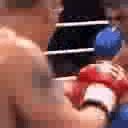

In [ ]:
def prepare_single_video(frames):
    frame_features = np.zeros(shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32")

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[None, ...]

    # Extract features from the frames of the current video.
    for i, batch in enumerate(frames):
        video_length = batch.shape[0]
        length = min(MAX_SEQ_LENGTH, video_length)
        for j in range(length):
            if np.mean(batch[j, :]) > 0.0:
                frame_features[i, j, :] = feature_extractor.predict(batch[None, j, :])
            else:
                frame_features[i, j, :] = 0.0

    return frame_features


def predict_action(path):
    class_vocab = label_processor.get_vocabulary()

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    probabilities = trained_model.predict(frame_features)[0]

    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i] * 100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
    converted_images = images.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
to_gif(test_frames[:MAX_SEQ_LENGTH])

In [ ]:
train_df.head()

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot


In [ ]:
test_df.head()

,video_name,tag
0,v_CricketShot_g01_c01.avi,CricketShot
1,v_CricketShot_g01_c02.avi,CricketShot
2,v_CricketShot_g01_c03.avi,CricketShot
3,v_CricketShot_g01_c04.avi,CricketShot
4,v_CricketShot_g01_c05.avi,CricketShot
